### Import all necessary libraries 

In [1]:
#importing tensorflow
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
# importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=1) # setting font scale
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

### Importing data

In [3]:
#mouting the drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
#Defining the path of the dataset
project_path = '/content/drive/My Drive/A - Learning/'
dataset_file = project_path + 'bank.csv'

#reading dataset
data = pd.read_csv(dataset_file)

## 1) Overview of Dataset

In [5]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Let's check the missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


- There are 10,000 customers and 14 variables including the target variable "Exited".
- There are no null values in any of the column.

In [7]:
#Number of distinct categories or classes in "Exited" column i.e., whether the customer left the bank within six months or not.
data['Exited'].nunique()

2

- As expected, there are only 2 classes.

In [8]:
# let's dive into numerical variables
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
data[num_cols].describe()

,CreditScore,Age,Tenure,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,199992.480000


- Noticed that the median value of Balance is much larger than its mean value. There are outliers at the lower end and we could see that it is because there are some zero values. However, in the real world scenario it does make sense to have zero balance in a bank account, especially for this inactive customers. Hence, we will not treat the outliers.
- The median values of other variables are approx to their respective mean values.
- The max number of years for which customers have been with the bank is 10 years. 
- The youngest customers are 18 years old, which is reasonable.

In [9]:
# let's also take a closer look at the categorical variables
cat_cols = ['Surname', 'Geography', 'Gender', 'NumOfProducts', 
           'HasCrCard', 'IsActiveMember', 'Exited' ]

# Printing number of count of each unique value in each column
for col in cat_cols:
  print(data[col].value_counts())
  print("-" * 50)

Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Bradbury     1
Coffman      1
Maitland     1
Ndubuisi     1
Angel        1
Name: Surname, Length: 2932, dtype: int64
--------------------------------------------------
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
--------------------------------------------------
Male      5457
Female    4543
Name: Gender, dtype: int64
--------------------------------------------------
1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64
--------------------------------------------------
1    7055
0    2945
Name: HasCrCard, dtype: int64
--------------------------------------------------
1    5151
0    4849
Name: IsActiveMember, dtype: int64
--------------------------------------------------
0    7963
1    2037
Name: Exited, dtype: int64
--------------------------------------------------


- There are quite a good mix of customers from different genders and whether they are active members of the bank.
- Most customers have purchased 1 to 2 products through the banks.
- Majority of the customers has a credit card.
- The customers are from any of these three countries France,Germany, and Spain.
- There are 2932 unique surnames and this variable doesn't really contribute any meaningful insights to our analysis, so we will proceed to drop this column.
- On the other hand, 'RowNumber' and 'CustomerId' are all unique values, we shall drop them too.

In [10]:
# dropping redundant columns
data.drop(['RowNumber', 'CustomerId', 'Surname'],axis=1,inplace=True)

## 2) EDA

In [11]:
#checking the percentage of each class in the dataset
(data.Exited.value_counts())/(data.Exited.count())

0    0.7963
1    0.2037
Name: Exited, dtype: float64

- The dataset is quite imbalanced. There are 79.63% of customers did not leave the bank and only 20.37% did leave the bank. 

### 2.1) Bivariate Analysis

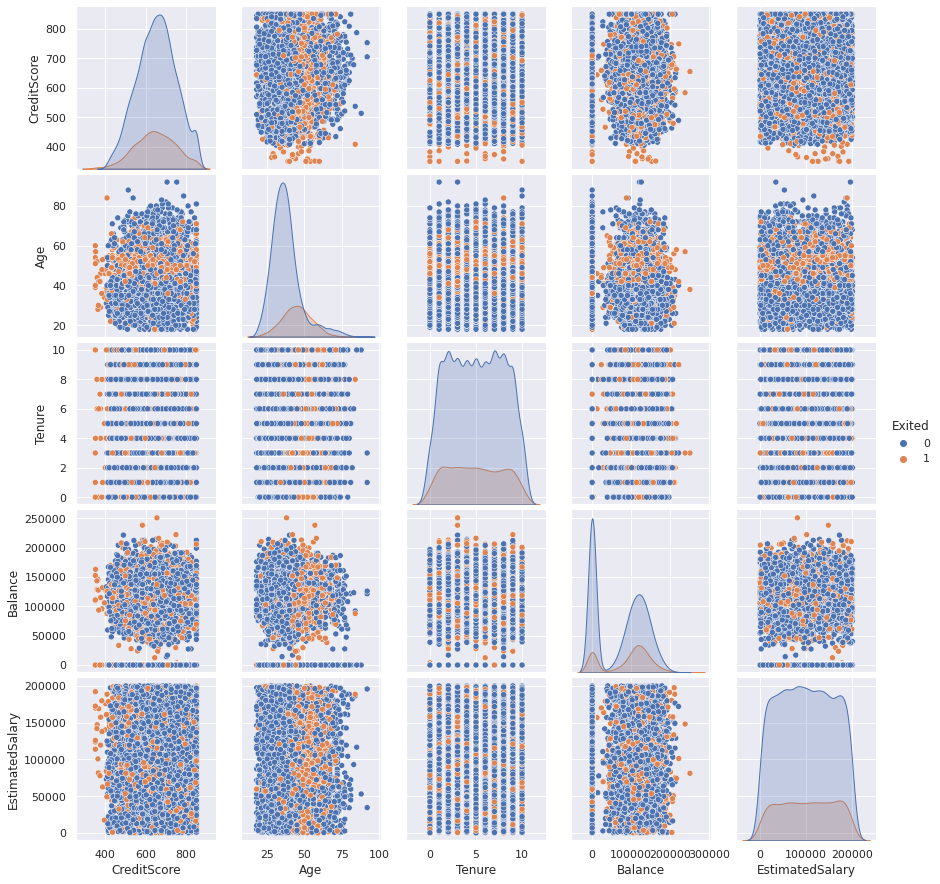

In [12]:
compare_cols = num_cols + ['Exited']
sns.pairplot(data[compare_cols],hue = 'Exited')
plt.show()

- We can see that none of the paired variables have linear relationship with each other.

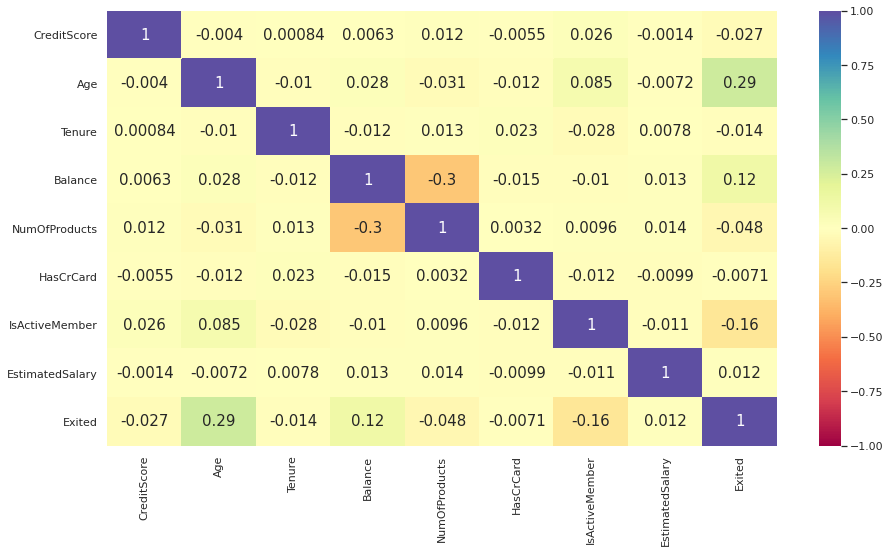

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(data.corr(),cmap="Spectral",ax=ax,annot=True, annot_kws={'size':15},vmin=-1,vmax=1)

- There isn't any signifiant correlation relationship among the variables.

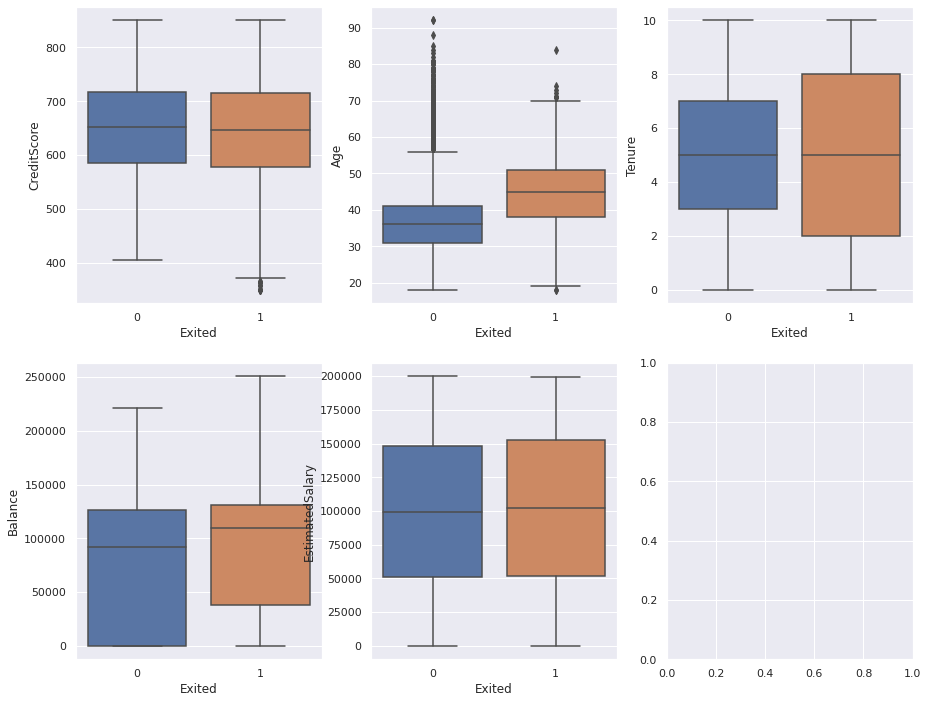

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(15,12))
row = 0
column = 0
for i, variable in enumerate(num_cols):
  if i>2:
    row = 1
    column = i-3
  sns.boxplot(x="Exited", y=variable, ax=axs[row,column], data=data, orient="vertical") 
  column += 1 
plt.show()

- There are some outliers with credit score lesser than the lower whisker of CreditScore boxplot who left the bank. Unlike those who had health credit score, this group of customers probably had very bad repayment conduct so the bank terminated the service towards them. These outliers represent real world scenario so we won't treat it.
- Turned out that older customers tend to leave the bank. The outliers also represent real world scenario so we won't treat it.
- Interestingly, customers who left the bank tend to have high account balance than those who stay with the bank.
- EstimatedSalary doesn't really have any insightful info towards whether a customer left the bank.

In [15]:
## Function to plot stacked bar chart
def stacked_plot(x):
    sns.set(palette="nipy_spectral")
    tab1 = pd.crosstab(x, data['Exited'], margins=True)
    print(tab1)
    print("-" * 110)
    tab = pd.crosstab(x, data['Exited'], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(15, 5))
    plt.show()

#### Exited vs Geography:

Exited        0     1    All
Geography                   
France     4204   810   5014
Germany    1695   814   2509
Spain      2064   413   2477
All        7963  2037  10000
--------------------------------------------------------------------------------------------------------------


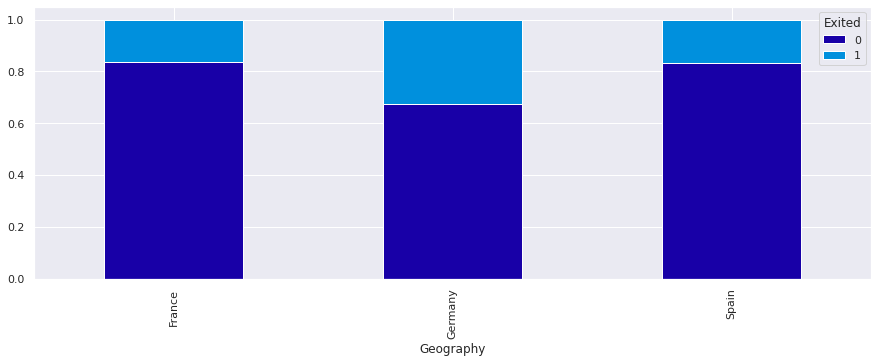

In [16]:
stacked_plot(data['Geography'])

- A larger proportion of customers in Germany left the bank compared with the other two locations.

#### Exited vs Gender:

Exited     0     1    All
Gender                   
Female  3404  1139   4543
Male    4559   898   5457
All     7963  2037  10000
--------------------------------------------------------------------------------------------------------------


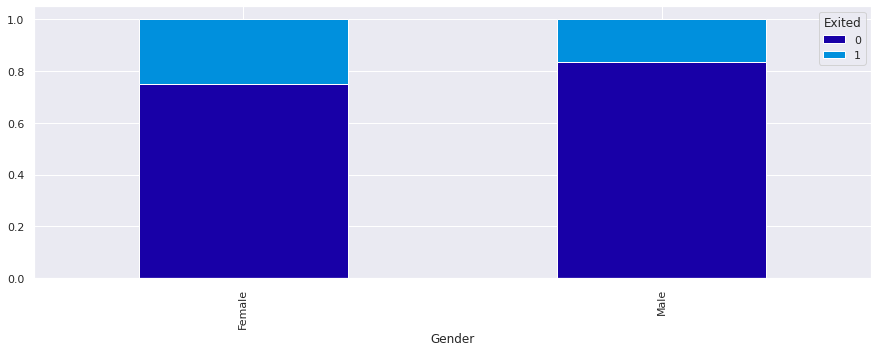

In [17]:
stacked_plot(data['Gender'])

- Relatively there are more female customers left the bank than the male customers did.

#### Exited vs NumOfProducts:

Exited            0     1    All
NumOfProducts                   
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
All            7963  2037  10000
--------------------------------------------------------------------------------------------------------------


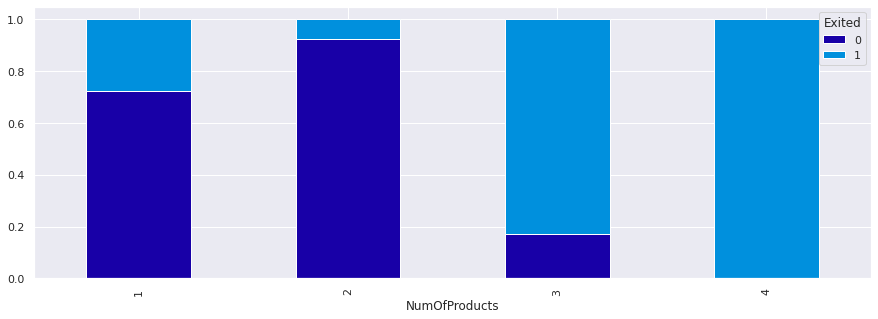

In [18]:
stacked_plot(data['NumOfProducts'])

- It appeared that customers who have purchased more than 2 products from the bank are significantly more likely to leave.
- Larger proportion of customers who only purchased 1 product from the bank left than customers who purchased 2 products. This is likely because those who tried out the bank the first time and didn't like it so they left. In contrast, those who had purchased 2 products are reasonably because they were satisfied with the first product purchased so they bought the second product and still stay with the bank.

#### Exited vs HasCrCard:

Exited        0     1    All
HasCrCard                   
0          2332   613   2945
1          5631  1424   7055
All        7963  2037  10000
--------------------------------------------------------------------------------------------------------------


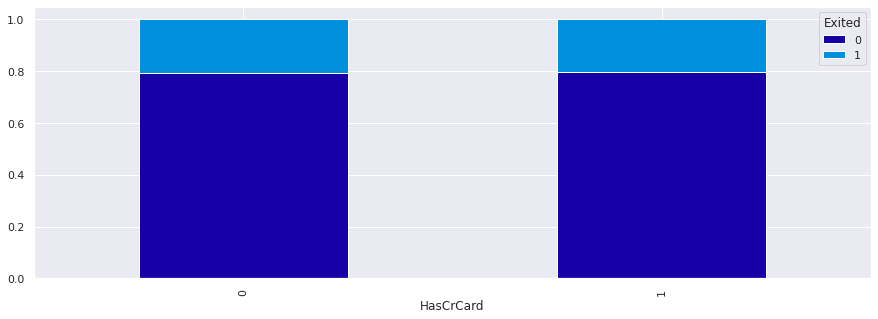

In [19]:
stacked_plot(data['HasCrCard'])

- Having a credit card or not doesn't seem to have any relation with customers' decision to leave the bank or not.

#### Exited vs IsActiveMember:

Exited             0     1    All
IsActiveMember                   
0               3547  1302   4849
1               4416   735   5151
All             7963  2037  10000
--------------------------------------------------------------------------------------------------------------


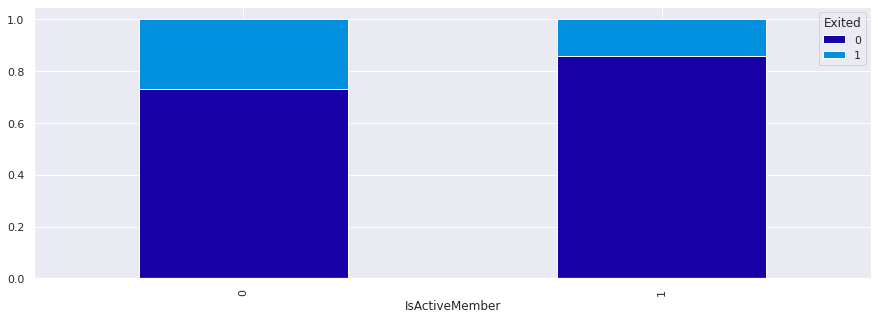

In [20]:
stacked_plot(data['IsActiveMember'])

- Customers who are inactive tend to leave the bank.

Since the max Tenure is only 10 and they are in discrete numbers, let's also plot a stacked bar chart for variable Tenure.
#### Exited vs Tenure:

Exited     0     1    All
Tenure                   
0        318    95    413
1        803   232   1035
2        847   201   1048
3        796   213   1009
4        786   203    989
5        803   209   1012
6        771   196    967
7        851   177   1028
8        828   197   1025
9        771   213    984
10       389   101    490
All     7963  2037  10000
--------------------------------------------------------------------------------------------------------------


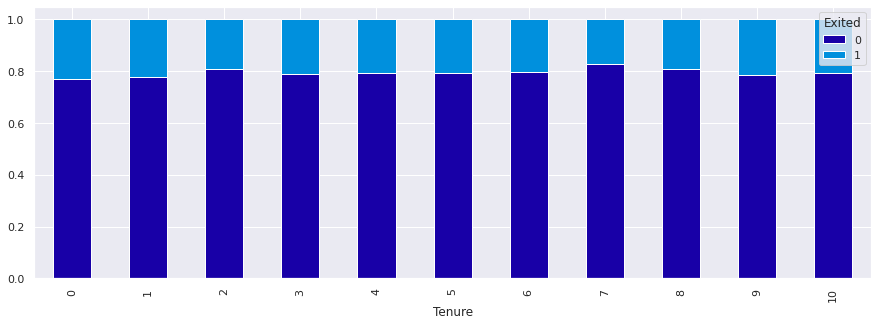

In [21]:
stacked_plot(data['Tenure'])

- The number of years a customer has been with the bank doesn't give any insightful info about whether the customer would likely leave the bank.

### 2.2) Other exploratory deep dive

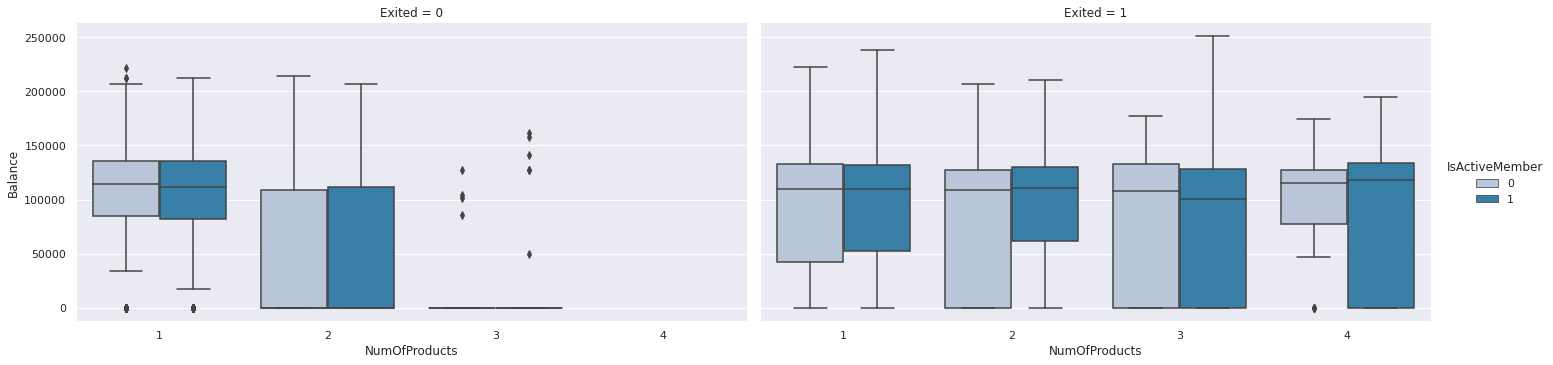

In [22]:
# compare multiple relevant categorical variables with customers' account balance simultenously
sns.catplot(x='NumOfProducts',y='Balance', col = 'Exited', hue='IsActiveMember', 
            data=data,kind='box', aspect=2, orient='v', palette='PuBu');

- From the boxplot we can see that: <br>
  i) those customers who have purchased 3 or 4 products from the bank, whether active or inactive, and regardless of account balance amounts, still left the bank. <br>
  ii) More customers of those who purchased 1 product from the bank and with lower account balance at around 50k to 80k left the bank.

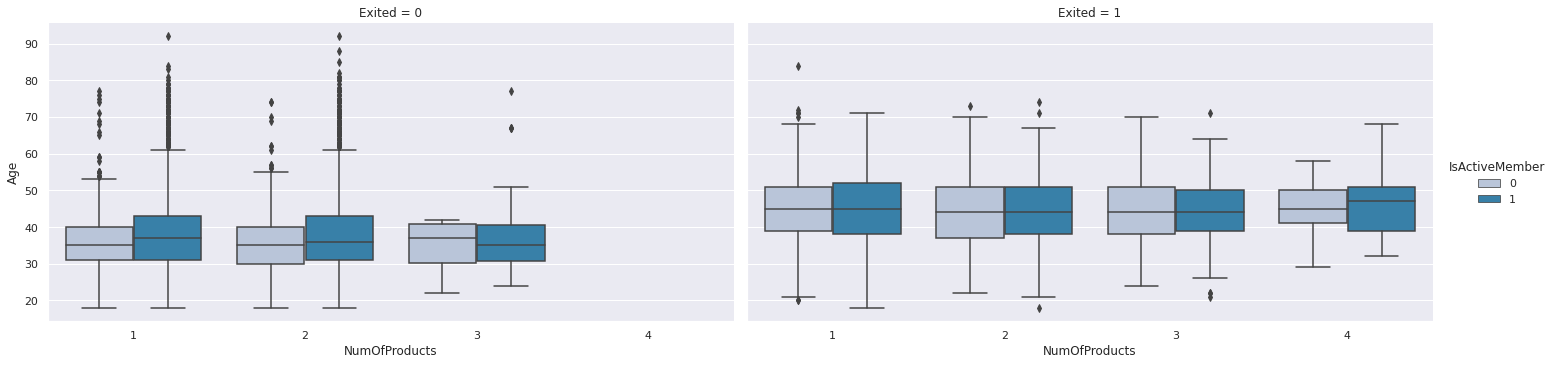

In [23]:
# compare multiple relevant categorical variables with customers' age simultenously
sns.catplot(x='NumOfProducts',y='Age', col = 'Exited', hue='IsActiveMember', 
            data=data,kind='box', aspect=2, orient='v', palette='PuBu');

- The boxplots above shows that customers who left the bank, whether they are active or inactive, and regardless of how many products they had purchased, are **generally older** than those who continue staying with the bank.

## 3) Data Pre-processing

In [24]:
df = pd.get_dummies(data,drop_first=True)
df = df.astype('float32') # converting the dataset to float in order to be able to convert it into tensors later.
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619.0,42.0,2.0,0.000000,1.0,1.0,1.0,101348.882812,1.0,0.0,0.0,0.0
1,608.0,41.0,1.0,83807.859375,1.0,0.0,1.0,112542.578125,0.0,0.0,1.0,0.0
2,502.0,42.0,8.0,159660.796875,3.0,1.0,0.0,113931.570312,1.0,0.0,0.0,0.0
3,699.0,39.0,1.0,0.000000,2.0,0.0,0.0,93826.632812,0.0,0.0,0.0,0.0
4,850.0,43.0,2.0,125510.820312,1.0,1.0,1.0,79084.101562,0.0,0.0,1.0,0.0


#### Splitting the target variable and predictors:

In [25]:
X = df.drop(["Exited"], axis=1)
y = df["Exited"]

#Splitting the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [26]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (8000, 11)
X_test shape: (2000, 11)


#### Normalizing the train and test data separately:

In [27]:
scaler = StandardScaler()

#fitting the transform on test and train separately
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4) Model building - Deep Neural Network

### <ins>Model Performance Evaluation Criterion</ins>

#### Model can make wrong predictions as:
* Predicting a customer would leave the bank but actually wouldn't leave; 
* Predicting a customer wouldn't leave the bank but actually would leave.


#### Which case is more important? 
* Predicting that customer wouldn't leave the bank but actually would leave. It would result in loss in revenue.

#### How to reduce this loss i.e need to reduce False Negative?
* The bank would want **`Recall`** to be maximized, greater the Recall higher the chances of minimizing false Negative. Hence, the focus should be on increasing Recall or minimizing the false Negative or in other words identifying the True Positive(i.e. Class 1) so that the Company can identify the which customer would leave.

### 4.1) Model 1

- We will use a simple NN made of 5 fully-connected layers with ReLu activation. The NN takes a vector of length 11 as input. This represents the information related to each transactions, ie each line with 11 columns from the dataset. For each transaction, the final layer <ins>will output a probability distribution (sigmoid activation function) and classify either as not exiting (0) or exiting (1).</ins>
- a dropout step is included to prevent overfitting.

In [28]:
#initialize the model
model1 = Sequential()

# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
model1.add(Dense(units=16, input_dim = 11,activation='relu'))   # input of 29 columns as shown above
# hidden layer
model1.add(Dense(units=24,activation='relu'))
#Adding Dropout to prevent overfitting 
model1.add(Dropout(0.3))
model1.add(Dense(24,activation='relu'))
model1.add(Dense(24,activation='relu'))
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (fraud or not)
# We use the sigmoid because we want probability outcomes
model1.add(Dense(1,activation='sigmoid'))    # binary classification fraudulent or not

In [29]:
# Use optimizer 'adam' with default learning rate
# Compile the model
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [30]:
#Let's print the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 1,825
Trainable params: 1,825
Non-trainable params: 0
______________________________________________________

In [31]:
#fitting the model
history=model1.fit(X_train,y_train,batch_size=15,epochs=10,validation_split=0.2)

Epoch 1/10
427/427 [==============================] - 2s 3ms/step - loss: 0.4916 - accuracy: 0.7956 - val_loss: 0.4375 - val_accuracy: 0.8100
Epoch 2/10
427/427 [==============================] - 1s 2ms/step - loss: 0.4273 - accuracy: 0.8145 - val_loss: 0.3890 - val_accuracy: 0.8375
Epoch 3/10
427/427 [==============================] - 1s 2ms/step - loss: 0.3948 - accuracy: 0.8306 - val_loss: 0.3674 - val_accuracy: 0.8419
Epoch 4/10
427/427 [==============================] - 1s 3ms/step - loss: 0.3813 - accuracy: 0.8395 - val_loss: 0.3609 - val_accuracy: 0.8469
Epoch 5/10
427/427 [==============================] - 1s 2ms/step - loss: 0.3760 - accuracy: 0.8436 - val_loss: 0.3584 - val_accuracy: 0.8438
Epoch 6/10
427/427 [==============================] - 1s 2ms/step - loss: 0.3703 - accuracy: 0.8445 - val_loss: 0.3502 - val_accuracy: 0.8537
Epoch 7/10
427/427 [==============================] - 1s 2ms/step - loss: 0.3614 - accuracy: 0.8511 - val_loss: 0.3466 - val_accuracy: 0.8506
Epoch 

#### Plotting the train and test loss:

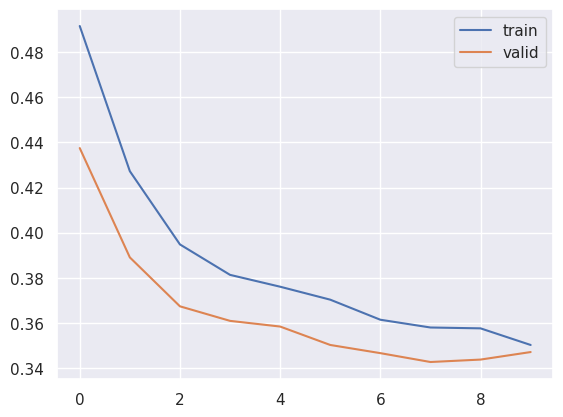

In [32]:
mpl.style.use('default')
sns.set(font_scale=1)
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#### Model Performance Evaluation:

In [33]:
score = model1.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.3443 - accuracy: 0.8580


- The model achieves an accuracy of 85.8%
- Remember that our dataset is mainly composed of customers who didn't leave the bank (79.63%). Consequently, a model predicting every customer as not exiting would achieve high accuracy despite being inefficient to identify customers who would leave.

In [34]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

#---------------------------------------------------------------------------------------------------------
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,train,test,train_y,test_y):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    for pred in [pred_train, pred_test]:
      for i in range(len(pred)):
          if pred[i]>0.5:
              pred[i]=1 
          else:
              pred[i]=0
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
    
    return score_list # returning the list with train and test scores

#### Now, let's Print confusion matrix: 

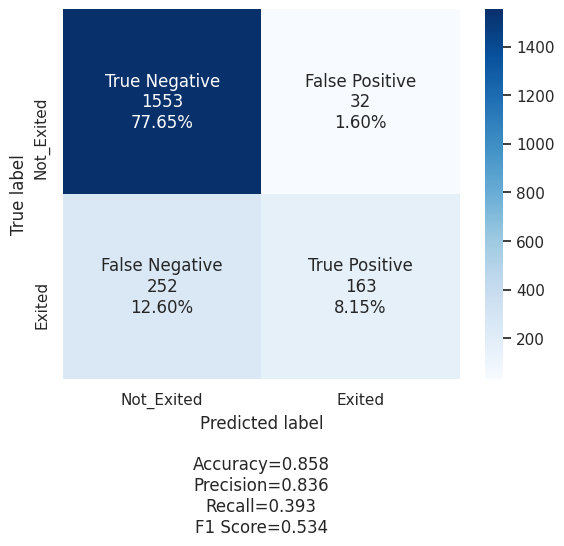

In [35]:
## Confusion Matrix on unsee test set
import seaborn as sn
y_pred1 = model1.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0

cm1=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

- The recall is only 0.393. There are 415 customers exited but 252 of them weren't itentified (false negative). Our objective must be to detect as many exited customers as possible since these can have a huge negative impact.
- We must find ways to further reduce the number of false negative.

### 4.2) Model 2
- Let's try another architecture to get the better Recall
- There are some basic Hyperparameters which can help to get the better model performance.

In [36]:
#Training Multi-layer perceptron with 2 hidden layers

#adding earlystopping callback
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=15,
                              verbose=0, mode='min', restore_best_weights= True)
model2 = Sequential()
#Initializing the weights uisng hue_normal 
model2.add(Dense(65, input_shape=(X_train.shape[1], ), kernel_initializer='he_normal', activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(65, kernel_initializer='he_normal', activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

model2.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
his_mod2= model2.fit(X_train, y_train, validation_split=0.2, batch_size=300, epochs=40, callbacks=[es], shuffle=True, verbose=1)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/40
22/22 [==============================] - 1s 13ms/step - loss: 1.0539 - accuracy: 0.5487 - val_loss: 0.6263 - val_accuracy: 0.7975
Epoch 2/40
22/22 [==============================] - 0s 6ms/step - loss: 0.7628 - accuracy: 0.7184 - val_loss: 0.5459 - val_accuracy: 0.7981
Epoch 3/40
22/22 [==============================] - 0s 5ms/step - loss: 0.6747 - accuracy: 0.7139 - val_loss: 0.4837 - val_accuracy: 0.8006
Epoch 4/40
22/22 [==============================] - 0s 5ms/step - loss: 0.6256 - accuracy: 0.7334 - val_loss: 0.4756 - val_accuracy: 0.8012
Epoch 5/40
22/22 [==============================] - 0s 6ms/step - loss: 0.5861 - accuracy: 0.7506 - val_loss: 0.4604 - val_accuracy: 0.8012
Epoch 6/40
22/22 [==============================] - 0s 6ms/step - loss: 0.5592 - accuracy: 0.7644 - val_loss: 0.4546 - val_accuracy: 0.8025
Epoch 7/40
22/22 [==============================] - 0s 6ms/step - loss: 0.5553 - accuracy: 0.7645 - val_loss: 0.4499 - val_accuracy: 0.8050
Epoch 8/40
22/22 [=

#### Plotting the train and validation loss:

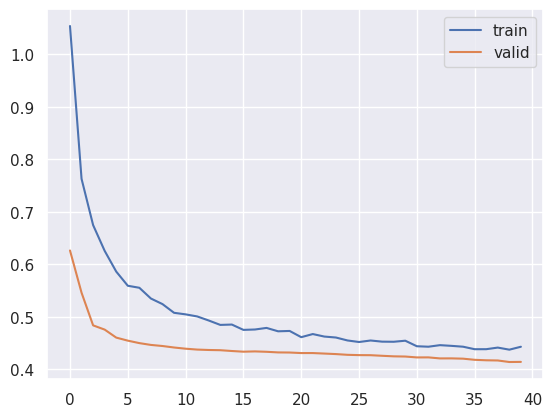

In [37]:
# Capturing learning history per epoch
hist  = pd.DataFrame(his_mod2.history)
hist['epoch'] = his_mod2.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#### Plotting confusion matrix:

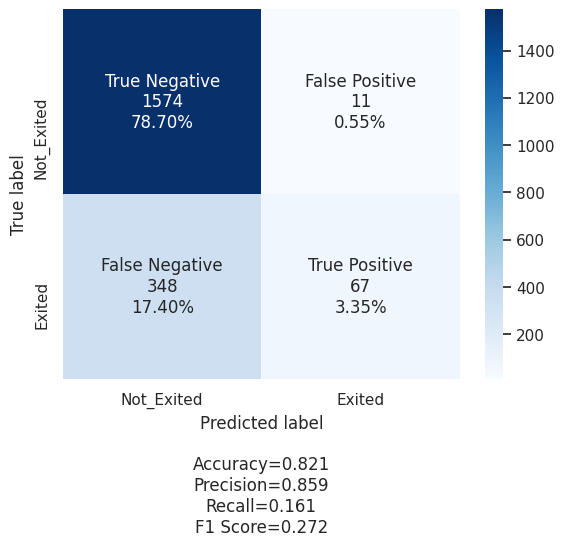

In [38]:
## Confusion Matrix on unsee test set
import seaborn as sn
y_pred2 = model2.predict(X_test)
for i in range(len(y_test)):
    if y_pred2[i]>0.5:
        y_pred2[i]=1 
    else:
        y_pred2[i]=0

cm2=confusion_matrix(y_test, y_pred2)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

- As you can see here the Recall of the model is not improved and it is worse than the previous ANN model but the precision has improved.

#### Weighted loss to account for large class imbalance in train dataset
- we will adjust the class imbalance by giving additional weight to the loss associated to errors made on the detection exited customers.
We will use our first ANN model and apply weighted loss. Let's review the process:

In [39]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), np.array([y_train.iloc[i] for i in range(len(y_train))]))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6271558482282847, 1: 2.466091245376079}

- The class 'Exited' (y=1) is assigned a weight of 2.466 vs 0.627 for the class 'Not Exited' due to the low prevalence we detected during data exploration. This allows the model to give more importance to the errors made on Exited cases during training.

Training the model:

In [40]:
model1.fit(X_train,y_train,batch_size=15,epochs=5, class_weight=class_weights, shuffle=True)

Epoch 1/5
534/534 [==============================] - 2s 3ms/step - loss: 0.4861 - accuracy: 0.7910
Epoch 2/5
534/534 [==============================] - 2s 3ms/step - loss: 0.4790 - accuracy: 0.7910
Epoch 3/5
534/534 [==============================] - 2s 3ms/step - loss: 0.4753 - accuracy: 0.7895
Epoch 4/5
534/534 [==============================] - 2s 3ms/step - loss: 0.4685 - accuracy: 0.7912
Epoch 5/5
534/534 [==============================] - 1s 3ms/step - loss: 0.4636 - accuracy: 0.7906


In [41]:
score_weighted = model1.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.4237 - accuracy: 0.8095


#### Plotting confusion matrix:

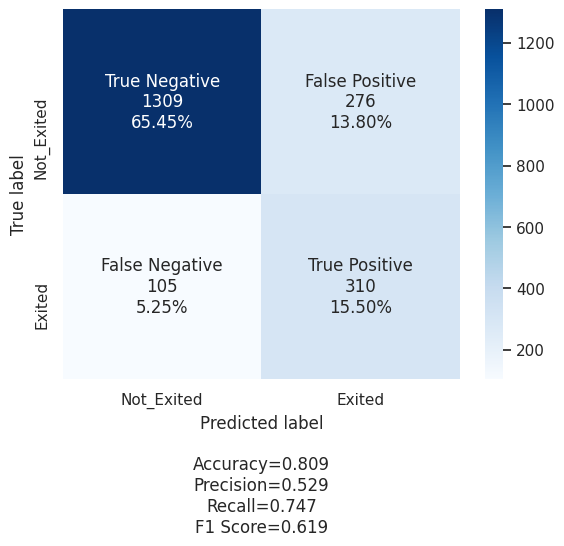

In [42]:
## Confusion Matrix on unsee test set
import seaborn as sn
y_pred1 = model1.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0

cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Not_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

#### Result:

We can see here the Recall has increased but the precision became very bad. There is still lot of scope of improvements as follows: <br>
1) Threshold can be tuned to get the optimal value <br>
2) Resampling techniques can be applied to balanced the data and then train the model <br>
3) Hyperparameter tuning can be applied to tune the different Hyperparameters <br>
We can select the Model-1 with adjusted class weight for further performance improvement through tunning threshold

## 5) Model Performance Improvement
### Let's try find the optimal threshold using **ROC-AUC curve**:


ROC-AUC on training set:


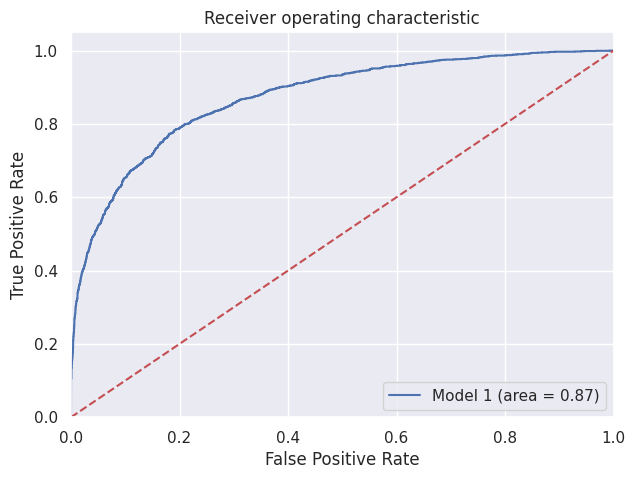

In [43]:
# ROC-AUC on training set
print("\nROC-AUC on training set:")
roc_auc_train = roc_auc_score(y_train, model1.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, model1.predict(X_train))
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Model 1 (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


ROC-AUC on test set:


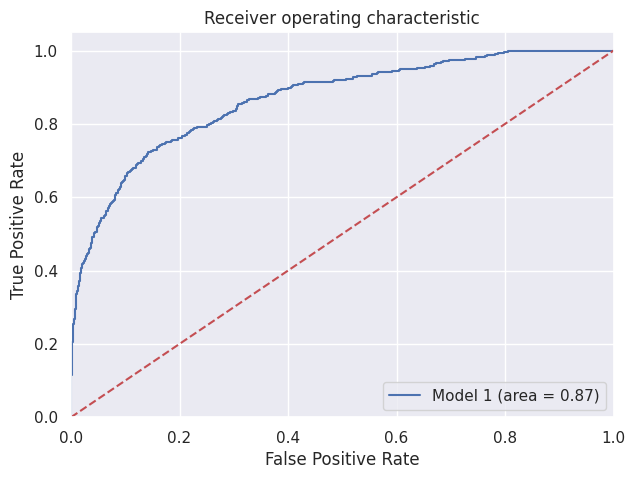

In [44]:
# ROC-AUC on test set
print("\nROC-AUC on test set:")
roc_auc_test = roc_auc_score(y_test, model1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model1.predict(X_test))
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Model 1 (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

- Model 1 has given a generalized performance on training and test set.
- Recall is less and we should try to improve it.
- Let's change the threshold to see if the model performance can be improved.

### Optimal threshold using AUC-ROC curve:

In [45]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_test, model1.predict(X_test))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Model prediction with optimal threshold
pred_train_opt = (model1.predict(X_train)>optimal_threshold)
pred_test_opt = (model1.predict(X_test)>optimal_threshold)
print(optimal_threshold)

0.5509649


### 5.1) Model 3

In [46]:
# Model prediction with optimal threshold

pred_train_opt = (model1.predict(X_train)>optimal_threshold)
pred_test_opt = (model1.predict(X_test)>optimal_threshold)

train_acc = accuracy_score(y_train, pred_train_opt)
test_acc  = accuracy_score(y_test, pred_test_opt)

print('Accuracy on train data:',train_acc)
print('Accuracy on test data:',test_acc)

train_rec = recall_score(y_train, pred_train_opt)
test_rec  = recall_score(y_test, pred_test_opt)

print('Recall on train data:',train_rec)
print('Recall on test data:',test_rec)

train_prec = precision_score(y_train, pred_train_opt)
test_prec  = precision_score(y_test, pred_test_opt)

print('Precision on train data:',train_prec)
print('Precision on test data:',test_prec)

train_roc = roc_auc_score(y_train, pred_train_opt)
test_roc  = roc_auc_score(y_test, pred_test_opt)

print('ROC-AUC Score on train data:',train_roc)
print('ROC-AUC Score on test data:',test_roc)

scores_optimal = []
scores_optimal.extend((train_acc,test_acc,train_rec,test_rec,train_prec,test_prec))

Accuracy on train data: 0.822125
Accuracy on test data: 0.8295
Recall on train data: 0.7256473489519112
Recall on test data: 0.7204819277108434
Precision on train data: 0.5461716937354988
Precision on test data: 0.5706106870229007
ROC-AUC Score on train data: 0.7861538720300478
ROC-AUC Score on test data: 0.7892630458743491


- Model is giving a generalized performance on training and test set;
- There isn't any improvement in the model performance because recall scores of both training and test set remain the same respectively.
- Area under the curve has decreased as compared to the initial model but the performance is generalized on training and test set.

### Now Let's also use Precision-Recall curve and see if we can find an even better threshold:

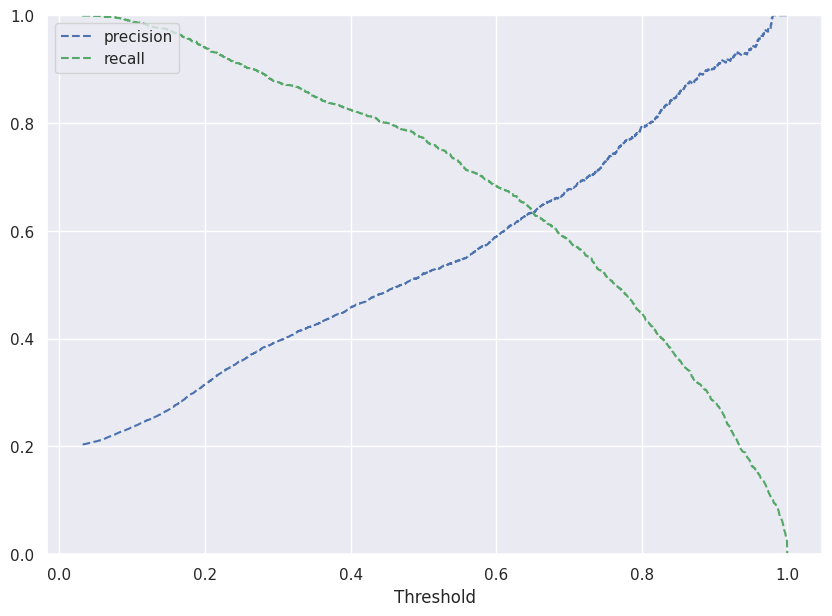

In [47]:
y_scores= model1.predict(X_train)
prec, rec, tre = precision_recall_curve(y_train, y_scores,)

# This function plots Precision-Recall curve
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
plt.figure(figsize=(10,7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

- At threshold around 0.65 we will get equal precision and recall but taking a step back and selecting value around 0.6 will provide a higher recall and a good precision.

### 5.2) Model 4

In [48]:
optimal_threshold = 0.6

# Model prediction with optimal threshold
pred_train_opt = (model1.predict(X_train)>optimal_threshold)
pred_test_opt = (model1.predict(X_test)>optimal_threshold)

#Model performance with optimal threhold

train_acc1 = accuracy_score(y_train, pred_train_opt)
test_acc1  = accuracy_score(y_test, pred_test_opt)

print('Accuracy on train data:',train_acc1)
print('Accuracy on test data:',test_acc1)

train_rec1 = recall_score(y_train, pred_train_opt)
test_rec1  = recall_score(y_test, pred_test_opt)

print('Recall on train data:',train_rec1)
print('Recall on test data:',test_rec1)

train_prec1 = precision_score(y_train, pred_train_opt)
test_prec1  = precision_score(y_test, pred_test_opt)

print('Precision on train data:',train_prec1)
print('Precision on test data:',test_prec1)

train_roc1 = roc_auc_score(y_train, pred_train_opt)
test_roc1  = roc_auc_score(y_test, pred_test_opt)

print('ROC-AUC Score on train data:',train_roc1)
print('ROC-AUC Score on test data:',test_roc1)

scores_prec_recall = []
scores_prec_recall.extend((train_acc1,test_acc1,train_rec1,test_rec1,train_prec1,test_prec1))

Accuracy on train data: 0.839125
Accuracy on test data: 0.843
Recall on train data: 0.6831072749691739
Recall on test data: 0.6771084337349398
Precision on train data: 0.5890483785220627
Precision on test data: 0.6095444685466378
ROC-AUC Score on train data: 0.7809547036495289
ROC-AUC Score on test data: 0.7817718824826119


- Model is performing well on training and test set.
- There's no improvement in the model performance.

In [49]:
# defining list of model
models = [model1, model2]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []


# looping through the models list to get the metrics score - Accuracy, Recall, and Precision
for model in models:
    
    j = get_metrics_score(model,X_train,X_test,y_train,y_test)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

In [50]:
# getting the scores of model with optimal threshold of 0.58 to get the metrics score - Accuracy, Recall, Precision, and F1 score
acc_train.append(scores_optimal[0])
acc_test.append(scores_optimal[1])
recall_train.append(scores_optimal[2])
recall_test.append(scores_optimal[3])
precision_train.append(scores_optimal[4])
precision_test.append(scores_optimal[5])

# getting the scores of model with optimal threshold of 0.71 to get the metrics score - Accuracy, Recall, Precision, and F1 score
acc_train.append(scores_prec_recall[0])
acc_test.append(scores_prec_recall[1])
recall_train.append(scores_prec_recall[2])
recall_test.append(scores_prec_recall[3])
precision_train.append(scores_prec_recall[4])
precision_test.append(scores_prec_recall[5])

In [51]:
comparison_frame = pd.DataFrame({'Model':['Skeleton ANN Model-1 with adjusted class weight',
                                          'ANN Model-2 with Tuned Hyperparameters',
                                          'ANN Model-1 - Optimal threshold = 0.5263',
                                          'ANN Model-1 - Optimal threshold = 0.6'],
                                          'Train_Accuracy':acc_train, 
                                          'Test_Accuracy':acc_test,
                                          'Train Recall':recall_train,
                                          'Test Recall':recall_test, 
                                          'Train Precision':precision_train,
                                          'Test Precision':precision_test
                                })                                
comparison_frame.sort_values(by='Test Recall',ascending=False)

,Model,Train_Accuracy,Test_Accuracy,Train Recall,Test Recall,Train Precision,Test Precision
0,Skeleton ANN Model-1 with adjusted class weight,0.809750,0.8095,0.771887,0.746988,0.520799,0.529010
2,ANN Model-1 - Optimal threshold = 0.5263,0.822125,0.8295,0.725647,0.720482,0.546172,0.570611
3,ANN Model-1 - Optimal threshold = 0.6,0.839125,0.8430,0.683107,0.677108,0.589048,0.609544
1,ANN Model-2 with Tuned Hyperparameters,0.825000,0.8205,0.162145,0.161446,0.865132,0.858974


<font color=darkblue> 
**Since our objective is to maximize Recall, we can <ins>select the initial skeleton Model-1 with adjusted class weight as our final model </ins> based on the above analysis.**

## 6) Conclusion and Key Takeaways:

-  If we put in more efforts to tune these hyperparameters, perhaps we will get some different combinations of weight initialization and dropout rate that might work better than the skeleton Model-1.
- The bank can track customers' activeness of making bank transactions. From there, the bank can target inactive members to entice them with some benefits in order to use the bank's products more regularly. 
- Customers who left the bank are mainly from older age group, especially those around 40-50 years old.
- Customer service of the bank in Germany should improve as it seems that more customers left the bank in Germany than other locations.
- It seems that customers' satisfication dropped after purchasing 3 or more products from the bank so they left. One reason could be because the bank has been giving good perks and service quality to those who only purchase 1 to 2 products. And as soon as a customer has purchased additional products, they don't get serviced with priority anymore. The bank should make effort to retain loyal customers who had purchased more products. 
